# Customer Segmentation
https://www.kaggle.com/blastchar/telco-customer-churn/  
https://towardsdatascience.com/clustering-algorithms-for-customer-segmentation-af637c6830ac  
https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a  

## <a name="table">Table of Contents</a> 

1. [Functions](#functions)  
<br>
2. [Preprocess Data](#preprocess)  

    2.1 [Load Data](#load)
    
    2.2 [NaN Values (i.e., " ?")](#nan)
    
    2.3 [Preprocessing Steps](#preprocessing)
3. [EDA](#eda)  

    3.1 [Categorical Variables](#categorical)
    
    3.2 [Target Variable](#target)

## <a name="functions">1. Functions</a> 
[Back to Table of Contents](#table)

In [207]:
# Data handling
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 

def load_preprocess_data():
    """ Load and preprocess data
    """
    
    # Load data
    df = pd.read_csv("data.csv")
    
    # remove empty values
    df = df.loc[df.TotalCharges!=" ", :]
    df.TotalCharges = df.TotalCharges.astype(float)
    
    # Label data correctly
    replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport','StreamingTV', 'StreamingMovies', 'Partner', 'Dependents',
                   'PhoneService', 'MultipleLines', 'PaperlessBilling', 'Churn']
    for i in replace_cols : 
        df.loc[:, i]  = df.loc[:, i].replace({'No internet service' : 'No', 'No phone service':'No'})
        df.loc[:, i]  = df.loc[:, i].map({'No':0, 'Yes':1})
    df.gender = df.gender.map({"Female":0, "Male":1})
    
    # One-hot encoding of variables
    others_categorical = ['Contract', 'PaymentMethod', 'InternetService']
    for i in others_categorical:
        df = df.join(pd.get_dummies(df[i], prefix=i))
    df.drop(others_categorical, axis=1, inplace=True)
    
    # Calculate number of services
    services = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
            'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'InternetService_DSL', 'InternetService_Fiber optic',
            'InternetService_No']
    df['nr_services'] = df.apply(lambda row: sum([row[x] for x in services[:-1]]), 1)
    
    return df.drop('customerID', 1)

def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_tsne(tnse_data, kmeans_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = kmeans_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="Set2")
    plt.show()
    
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(clustering)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    

    fig.update_traces(marker=dict(size=3))
    fig.show()
    
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tsne_3d_df['x'], tsne_3d_df['y'], tsne_3d_df['z'], c=tsne_3d_df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

## <a name="preprocess">2. Preprocess Data</a> 
[Back to Table of Contents](#table)

Demographic
* Gender
* SeniorCitizen
* Partner
* Dependents
* Tenure

Services
* PhoneService
* MultipleLines
* InternetService
* OnlineSecurity
* OnlineBackup
* DeviceProtection
* TechSupport
* StreamingTV
* StreamingMovies

Customer account information
* Contract
* PaperlessBilling
* PaymentMethod
* MonthlyCharges
* TotalCharges

Target
* Churn

No = 0
Yes = 1

Female = 0
Male = 1

In [89]:
df = load_preprocess_data()

## <a name="eda">3. EDA</a> 
[Back to Table of Contents](#table)

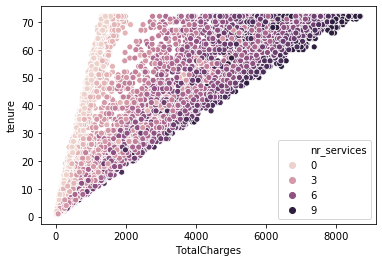

In [7]:
sns.scatterplot(df.TotalCharges, df.tenure, df.nr_services)

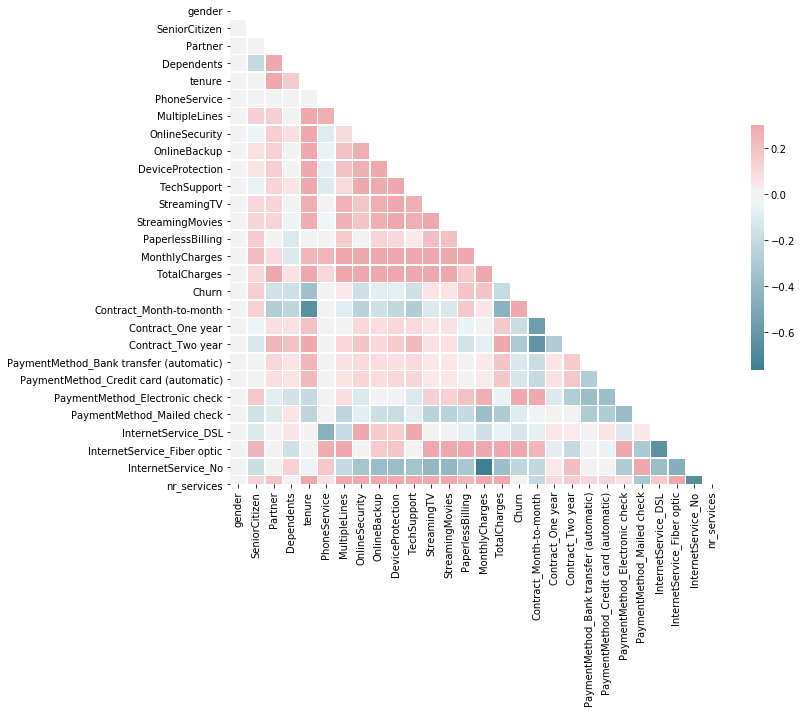

In [8]:
plot_corr(df)

## <a name="clustering">4. Clustering</a> 
[Back to Table of Contents](#table)

In [9]:
clustering = df.drop(["Churn"], 1)

### <a name="kmeans">4.1. k-Means</a> 
[Back to Table of Contents](#table)

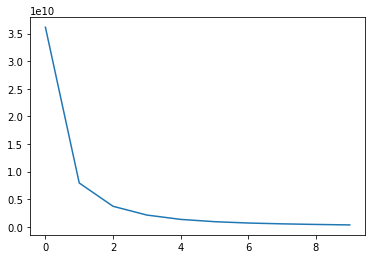

In [10]:
distances = []
for i in range(10):
    kmeans = KMeans(n_clusters=i+1)
    kmeans.fit(clustering)
    distances.append(kmeans.inertia_)
sns.lineplot(np.arange(0, 10), distances)

In [11]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### <a name="normalized">4.2. Normalized k-Means</a> 
[Back to Table of Contents](#table)

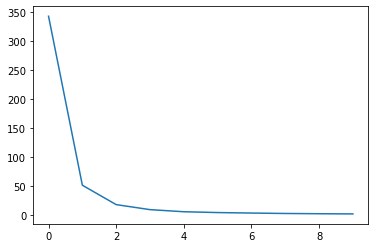

In [12]:
normalized_vectors = preprocessing.normalize(clustering)
normalized_distances = []
for i in range(10):
    normalized_kmeans = KMeans(n_clusters=i+1)
    normalized_kmeans.fit(normalized_vectors)
    normalized_distances.append(normalized_kmeans.inertia_)
sns.lineplot(np.arange(0, 10), normalized_distances)

In [314]:
normalized_kmeans = KMeans(n_clusters=4)
normalized_kmeans.fit(normalized_vectors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### <a name="dbscan">4.3. DBSCAN</a> 
[Back to Table of Contents](#table)

In [317]:
min_samples = clustering.shape[1]+1 #  Rule of thumb; number of dimensions D in the data set, as minPts ≥ D + 1
dbscan = DBSCAN(eps=3.5, min_samples=min_samples).fit(clustering)

## <a name="visualization">5. Visualization</a> 
[Back to Table of Contents](#table)

### <a name="tsne">5.1. t-SNE</a> 
[Back to Table of Contents](#table)

In [26]:
tsne_data = TSNE(n_components=2).fit_transform(clustering)

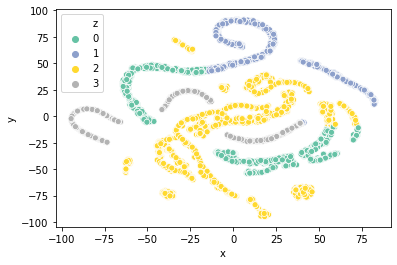

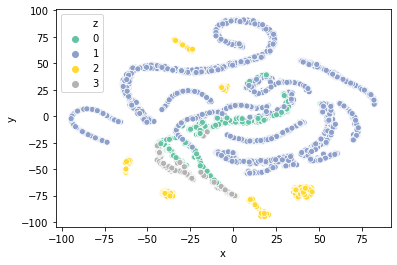

In [79]:
plot_tsne(tsne_data, kmeans.labels_)
plot_tsne(tsne_data, normalized_kmeans.labels_)

In [17]:
tsne_3d_df = prepare_tsne(3, clustering, kmeans.labels_)

In [18]:
plot_3d(tsne_3d_df)

In [307]:
tsne_3d_df['normalized_kmeans'] = normalized_kmeans.labels_
plot_3d(tsne_3d_df, name='normalized_kmeans')

In [318]:
min_samples = clustering.shape[1]+1 #  Rule of thumb; number of dimensions D in the data set, as minPts ≥ D + 1
dbscan = DBSCAN(eps=3.5, min_samples=min_samples).fit(clustering)
tsne_3d_df['dbscan'] = [str(label) for label in dbscan.labels_]
plot_3d(tsne_3d_df, name='dbscan')

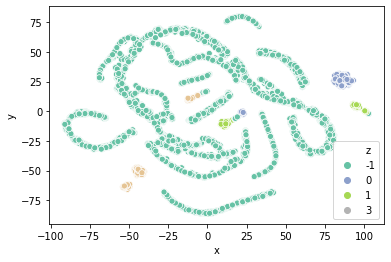

In [28]:
plot_tsne(tsne_data, dbscan.labels_)

### <a name="pca">5.2. PCA</a> 
[Back to Table of Contents](#table)

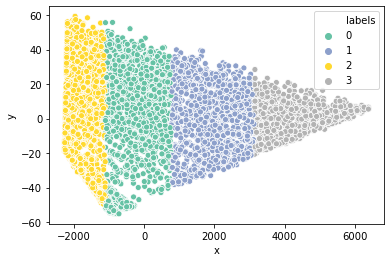

In [99]:
pca_df = prepare_pca(2, clustering, kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")

In [105]:
pca_df = prepare_pca(3, clustering, kmeans.labels_)
plot_3d(pca_df)

### <a name="3d">5.3. 3D Animation</a> 
[Back to Table of Contents](#table)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


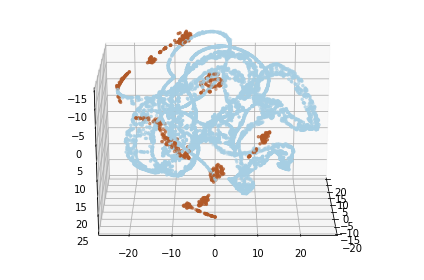

In [321]:
tsne_3d_df.dbscan = tsne_3d_df.dbscan.astype(int)
plot_animation(tsne_3d_df, 'normalized_kmeans', 'normalized_kmeans_new')

## <a name="evaluation">6. Evaluation</a> 
[Back to Table of Contents](#table)

There are some internal clustering methods. In particular with respect to the distances of objects in the data set. See for example Silhouette coefficient [on Wikipedia].

You must however be aware that there are algorithms such as k-means that try to optimize exactly these parameters, and as such you introduce a particular type of bias; essentially this is prone to overfitting.

So when using internal evaluation methods, you need to be well aware of the properties of your algorithm and the actual measures. I'd even try to do some kind of cross validation, using only part of the data for clustering, and another part of the data set to validation. For the silhouette coefficient this will probably not be enough to make anything except k-means look good, but at least it should help comparing different k-means results with each other. Which - for this reason - is actually the main use of such a coefficient: comparing different results of the same algorithm with each other.
https://stats.stackexchange.com/questions/21807/evaluation-measures-of-goodness-or-validity-of-clustering-without-having-truth

**Evaluation:**
* Silhouette score
    * Cross-validation?

### What makes a cluster unique?

One way to see the differences between clusters is to take the average value of each cluster and visualize it. 

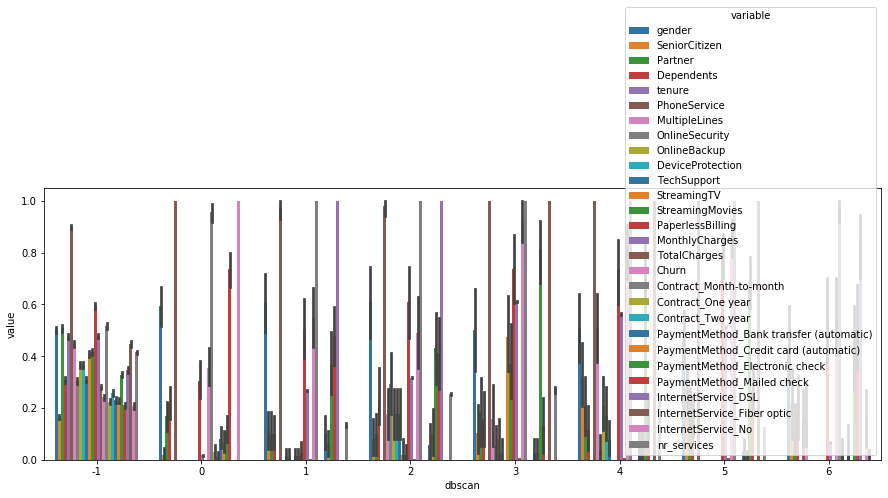

In [209]:
df = load_preprocess_data()
df['dbscan'] = dbscan.labels_
tidy = df_scaled.melt(id_vars='dbscan')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='dbscan', y='value', hue='variable', data=tidy, palette='tab10')

The problem with this approach is that we simply have too many variables. Not all of them are likely to be important when creating the clusters. Instead, I will select the most important columns based on the following approach: 

What I essentially do is group datapoints by cluster and take the average. Then, I calculate the standard deviation between
those values for each variable. Variables with a high standard deviation indicate that there are large differences between clusters and that the variable might be important. 

### DBSCAN

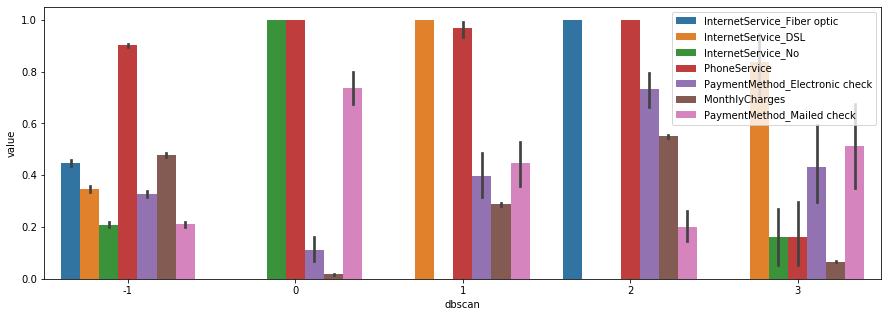

In [297]:
# Setting all variables between 0 and 1 in order to better visualize the results
df = load_preprocess_data().drop("Churn", 1)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns = df.columns
df_scaled['dbscan'] = dbscan.labels_

# Calculate variables with largest differences (by standard deviation)
# The higher the standard deviation in a variable based on average values for each cluster
# The more likely that the variable is important when creating the cluster
df_mean = df_scaled.loc[df_scaled.dbscan!=-1, :].groupby('dbscan').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_std[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['dbscan']

# Plot data
tidy = df_scaled[selected_columns].melt(id_vars='dbscan')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='dbscan', y='value', hue='variable', data=tidy, palette='tab10')
plt.legend(loc='upper right')